<a href="https://colab.research.google.com/github/Nabanita29/Research/blob/main/Intrusion_Detection_System_with_binary_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nslkdd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174616%2F394223%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T042735Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D79427363b0a5ca6f52f23e804c8ae6e4971064dff13e0ea198ed902b724df4221e2b304d90decc5ea391c6e4d0132173bfbc24ae5a44e5a55c114bd30dfdf5fcd630dc8a8457d9fc14179cf17960b7d8cd00508c05630a42e347603b8c4e214e55767e41932097570084b4eceadb1e7c34c5b958fe4a549001e95d9d4997e9e93ffbbf18bb5f66044ea2176883739371ff1e473c06c4ceefac62522c6114c1baf0df915483c658e2e0ea7ba61c72f77655ee47c575b08ba9acb1aed7195bf472fceba759df6c897cb0ddeb17e755dbc02375641c06783f28e0646fd28569a7727a9be61c6f0b27f030853dfa8f73250b0f01916bb8341cca66cbd8f57a2021b2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 14529600 bytes downloaded
Downloaded and uncompressed: nslkdd
Data source import complete.


<a id="1"></a> <br>
# Loading

In [3]:
#loading and importing data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, roc_auc_score
import scipy
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler


# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])


df_train=pd.read_csv('../input/nslkdd/KDDTrain+.txt',header=None,names=columns)
df_test=pd.read_csv('../input/nslkdd/KDDTest+.txt',header=None,names=columns)

In [4]:
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [5]:
# information of our data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

<a id="2"></a> <br>
# Check for duplicates

In [6]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [7]:
# Check for nissing data

In [8]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

<a id="3"></a> <br>
# checking for outliers

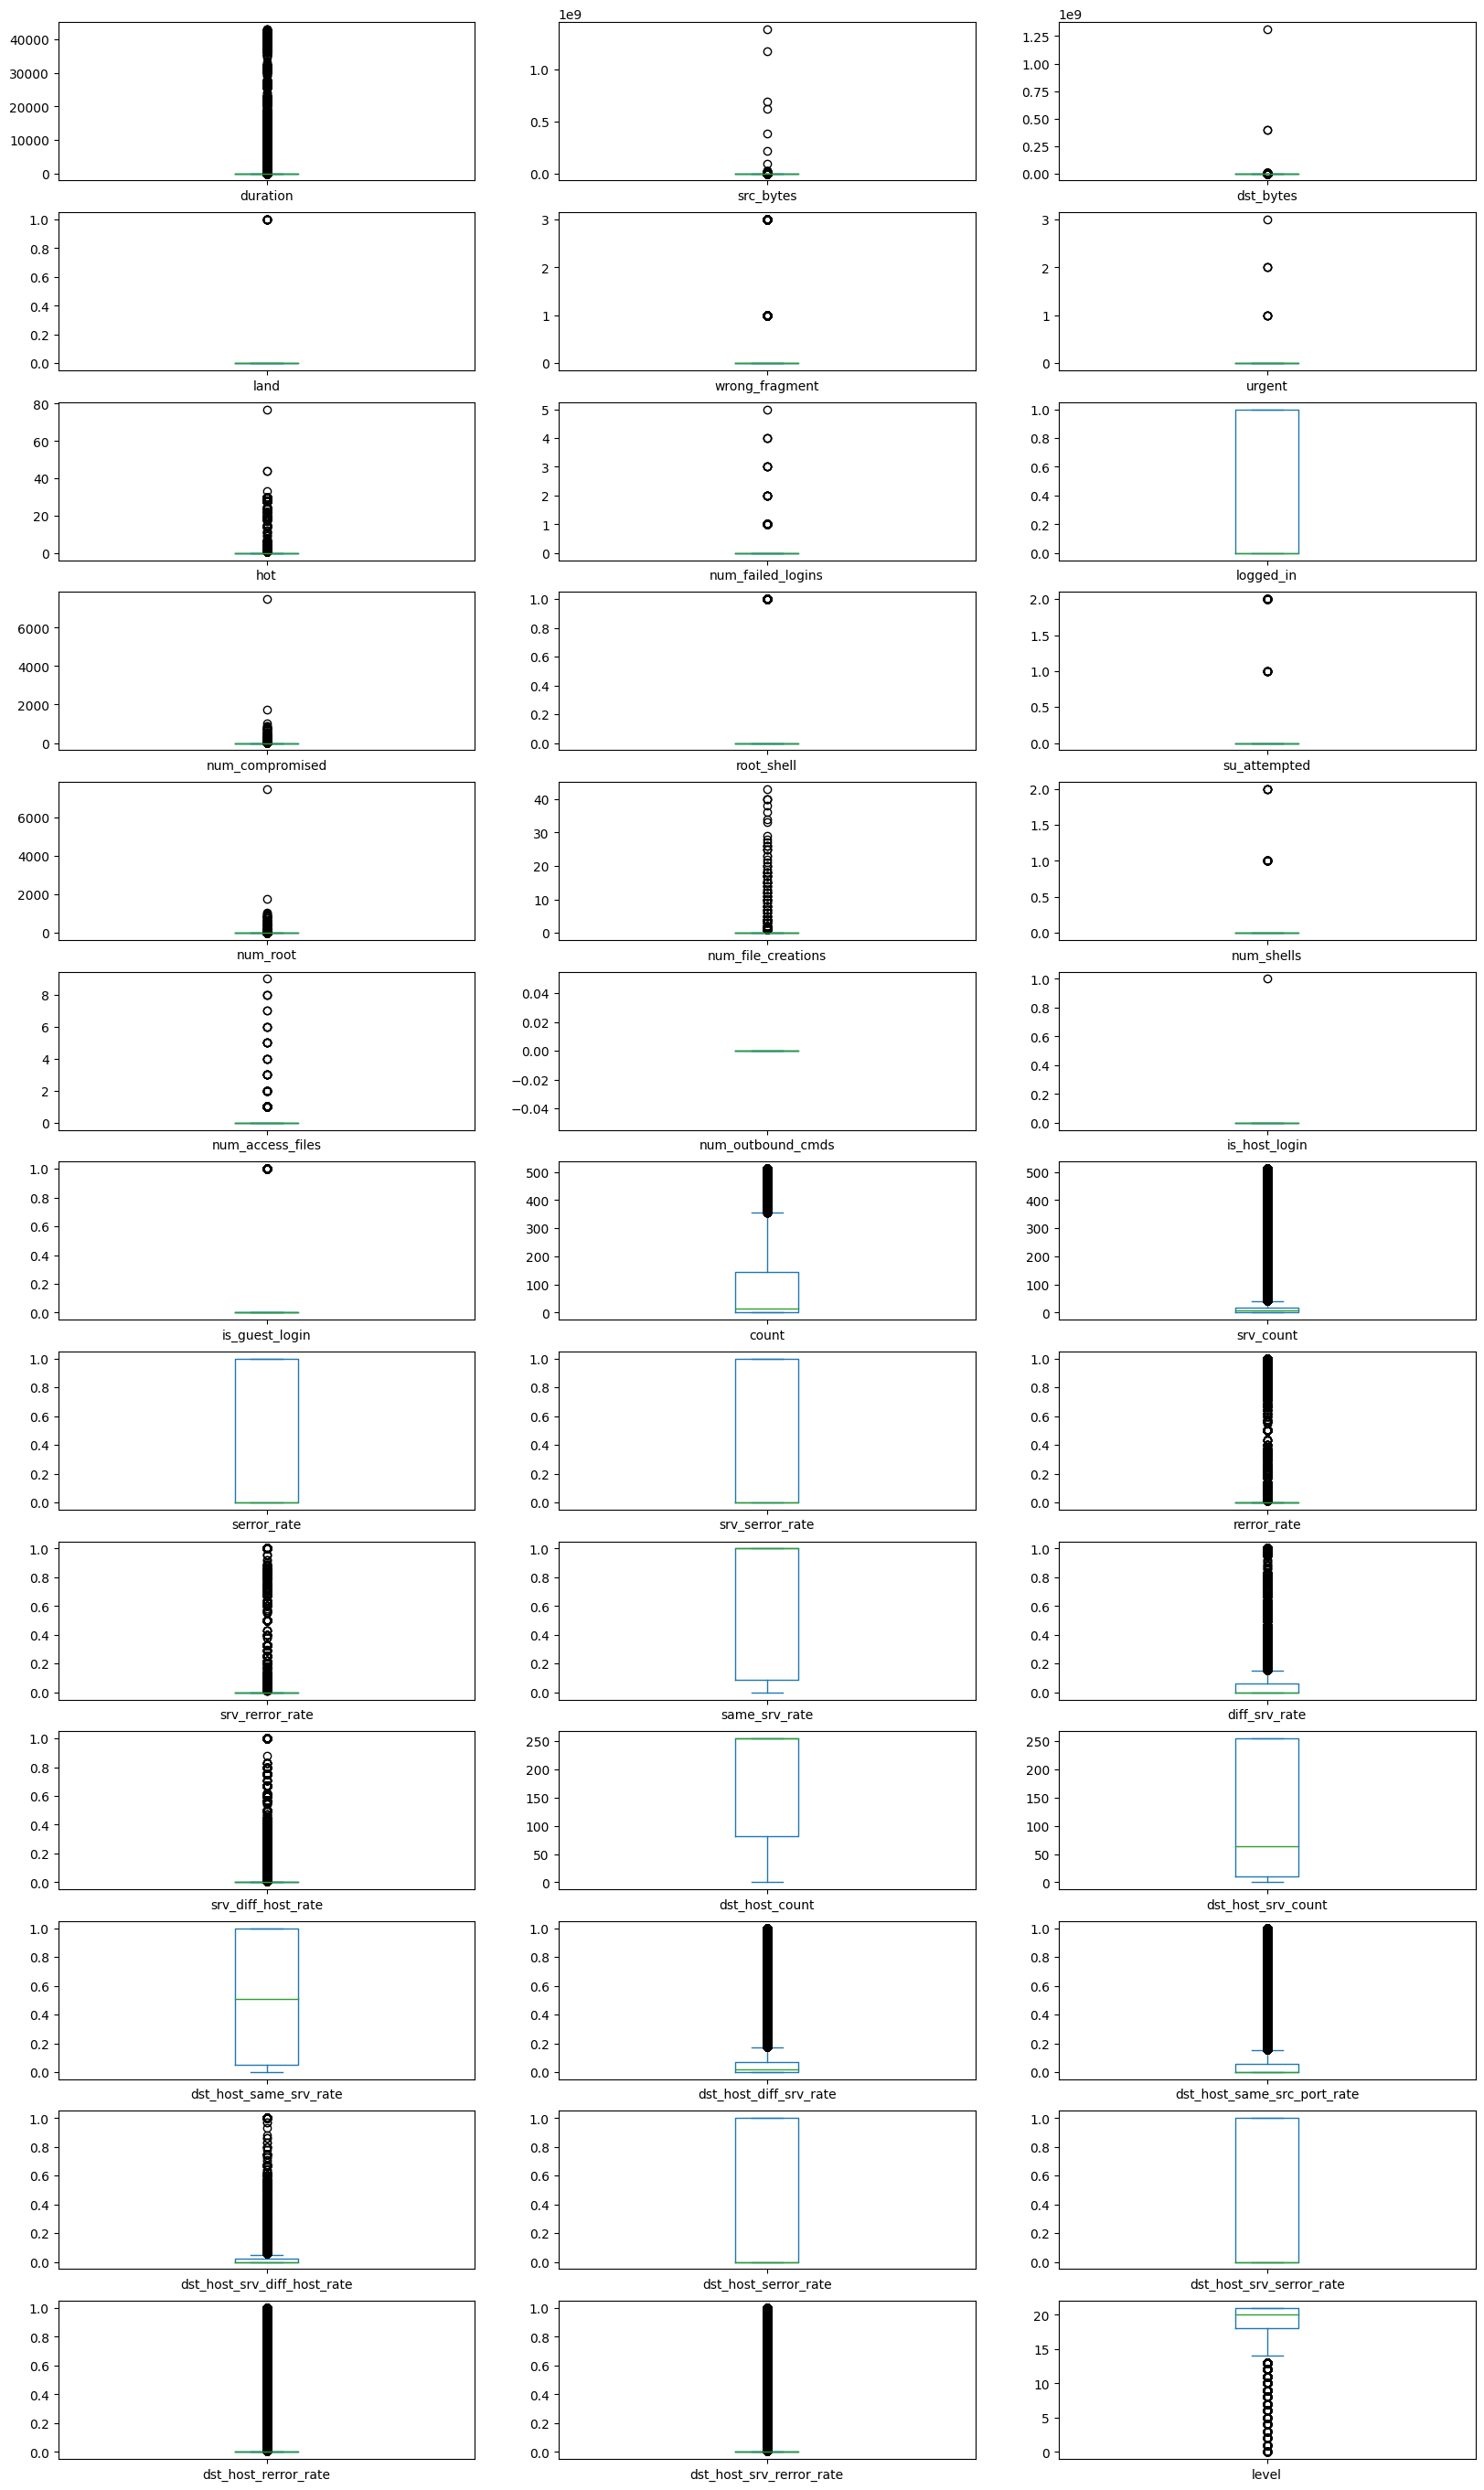

In [9]:
# Boxplot of all columns to see outliers
df_train.plot(kind='box', subplots=True, layout=(15,3), figsize=(20,40))
plt.show()


In [10]:
df_train['attack'].value_counts()

attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [11]:
# I will convert other abnormal classes to one class

df_train["binary_attack"]=df_train.attack.map(lambda a: "normal" if a == 'normal' else "abnormal")
df_train.drop('attack',axis=1,inplace=True)

df_test["binary_attack"]=df_test.attack.map(lambda a: "normal" if a == 'normal' else "abnormal")
df_test.drop('attack',axis=1,inplace=True)

In [12]:
df_train.select_dtypes(['object']).columns

Index(['protocol_type', 'service', 'flag', 'binary_attack'], dtype='object')

<a id="4"></a> <br>
# Encoding

In [13]:
# Label Encoder
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
clm=['protocol_type', 'service', 'flag', 'binary_attack']
for x in clm:
    df_train[x]=le.fit_transform(df_train[x])
    df_test[x]=le.fit_transform(df_test[x])


<a id="5"></a> <br>
# Spliting

In [14]:
#Spliting the data

x_train=df_train.drop('binary_attack',axis=1)
y_train=df_train["binary_attack"]

x_test=df_test.drop('binary_attack',axis=1)
y_test=df_test["binary_attack"]



<a id="6"></a> <br>
# Feature Engineering

In [15]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(x_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)

src_bytes                      0.565873
service                        0.469419
dst_bytes                      0.440041
flag                           0.370980
same_srv_rate                  0.366769
diff_srv_rate                  0.359129
dst_host_srv_count             0.337363
dst_host_same_srv_rate         0.312364
logged_in                      0.291474
dst_host_serror_rate           0.286227
dst_host_diff_srv_rate         0.286138
dst_host_srv_serror_rate       0.284135
serror_rate                    0.277163
srv_serror_rate                0.268664
count                          0.265328
dst_host_srv_diff_host_rate    0.187700
level                          0.151246
dst_host_count                 0.142508
dst_host_same_src_port_rate    0.131787
srv_diff_host_rate             0.099264
srv_count                      0.064574
dst_host_srv_rerror_rate       0.062161
protocol_type                  0.054150
rerror_rate                    0.043045
dst_host_rerror_rate           0.037449


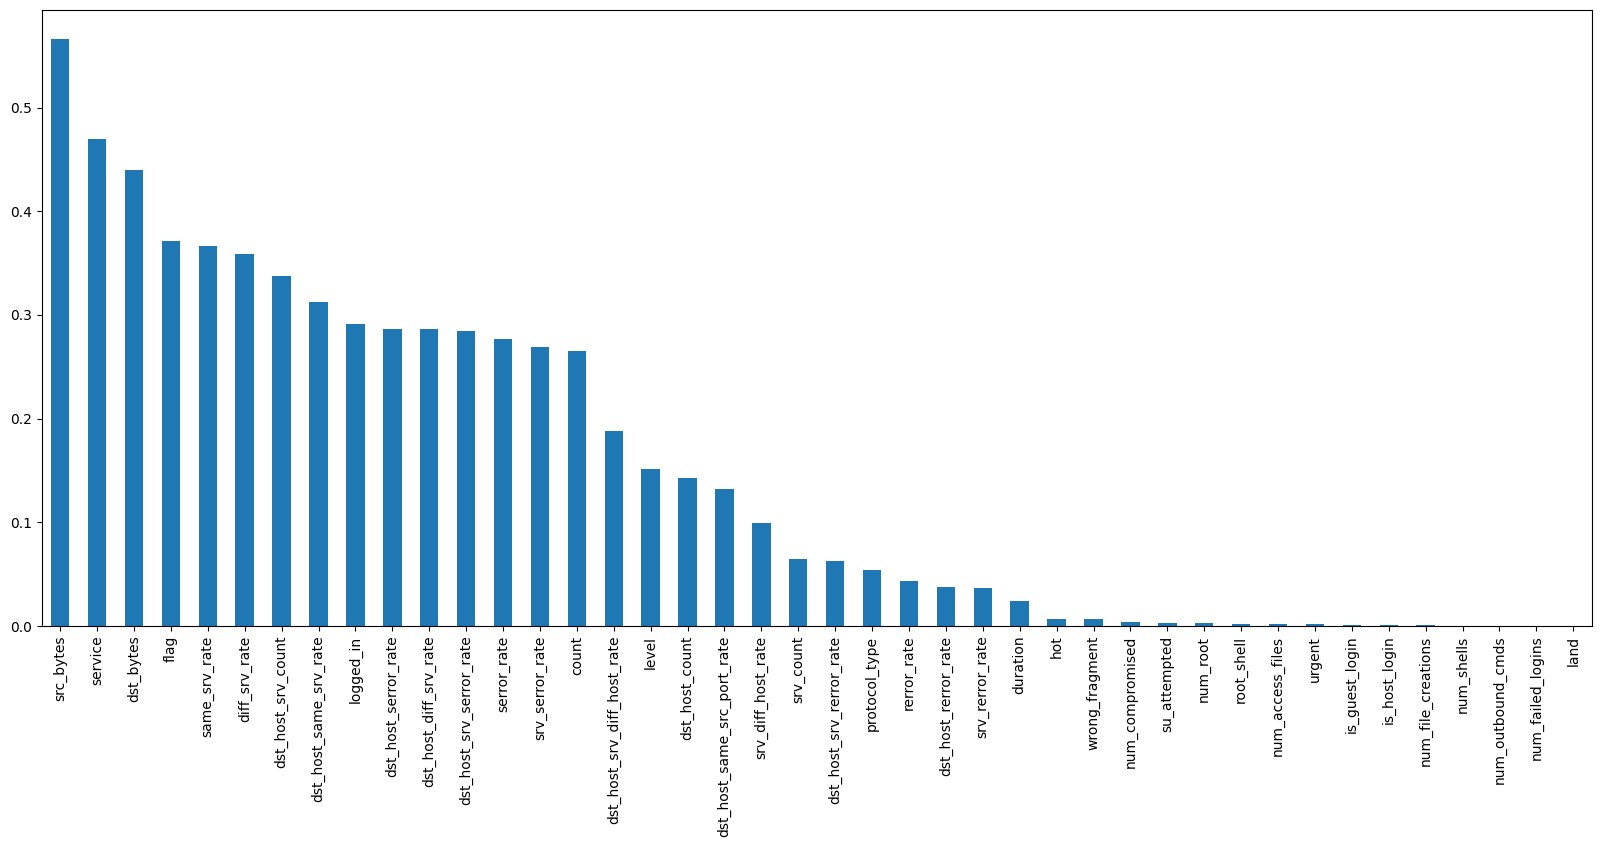

In [16]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8));


In [17]:
# I will choose 20 features to select
from sklearn.feature_selection import SelectKBest
sel_five_cols = SelectKBest(mutual_info_classif, k=20)
sel_five_cols.fit(x_train, y_train)
x_train.columns[sel_five_cols.get_support()]

Index(['service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'count',
       'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'level'],
      dtype='object')

In [18]:
col=['service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in',
       'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']
x_train=x_train[col]
x_test=x_test[col]

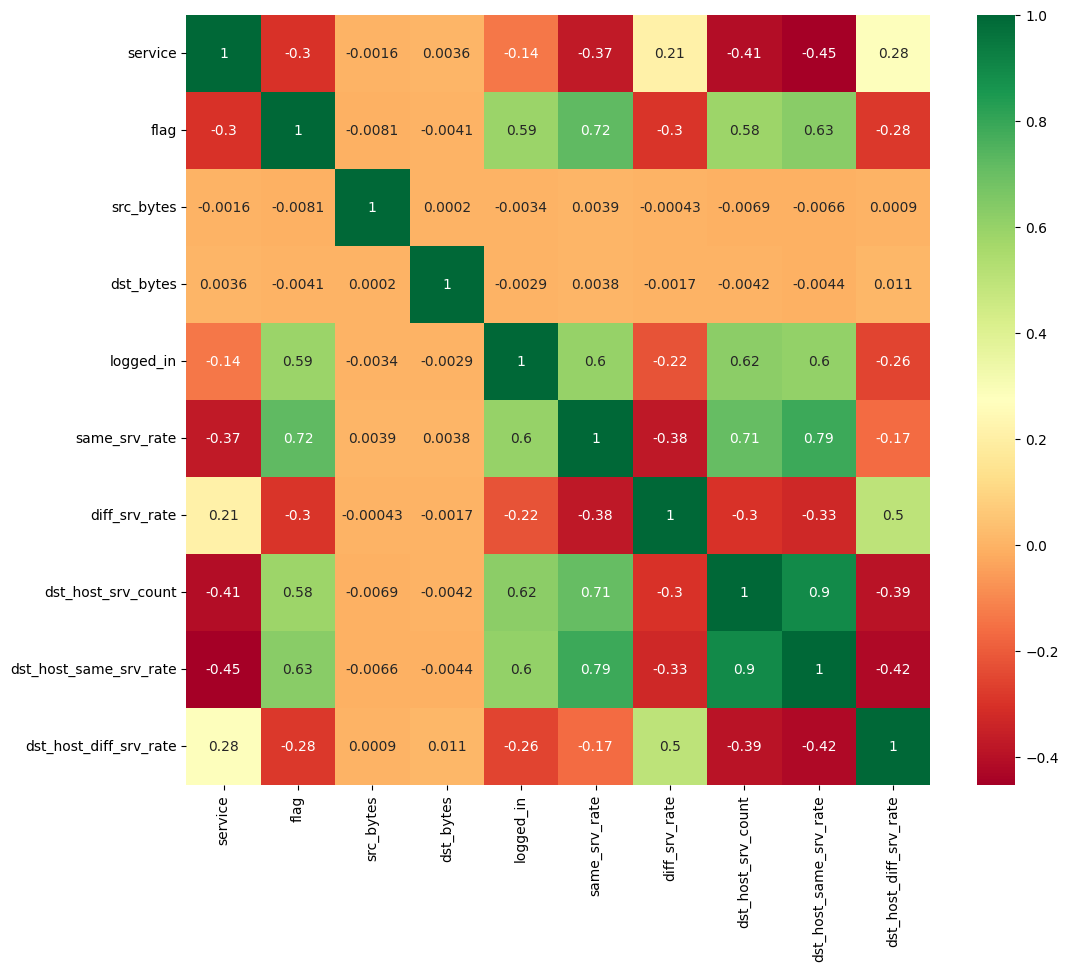

In [19]:
plt.figure(figsize=(12,10))
p=sns.heatmap(x_train.corr(), annot=True,cmap ='RdYlGn')

<a id="7"></a> <br>
# Scaling

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.fit_transform(x_test)

<a id="8"></a> <br>
# Binary classification models

In [21]:
# we'll initialize each model and store it by name in a dictionary
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines linear'] = LinearSVC()
models['Support Vector Machines plonomial'] = SVC(kernel='poly')
models['Support Vector Machines RBf'] =  SVC(C=100.0)

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier(max_depth=3)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier(n_neighbors=20)



In [22]:
# we'll loop over each one, train it by calling .fit(), make predictions, calculate metrics, and store each result in a dictionary.

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():

    # Fit the classifier
    models[key].fit(x_train, y_train)

    # Make predictions
    predictions = models[key].predict(x_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [23]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.717131,0.943981,0.611133
Support Vector Machines linear,0.723873,0.955617,0.615630
Support Vector Machines plonomial,0.764372,0.962723,0.653822
Support Vector Machines RBf,0.772933,0.957368,0.663977
Decision Trees,0.823013,0.840902,0.769579
Random Forest,0.752307,0.969313,0.640384
Naive Bayes,0.546265,0.440634,0.471463
K-Nearest Neighbor,0.788946,0.962002,0.680358


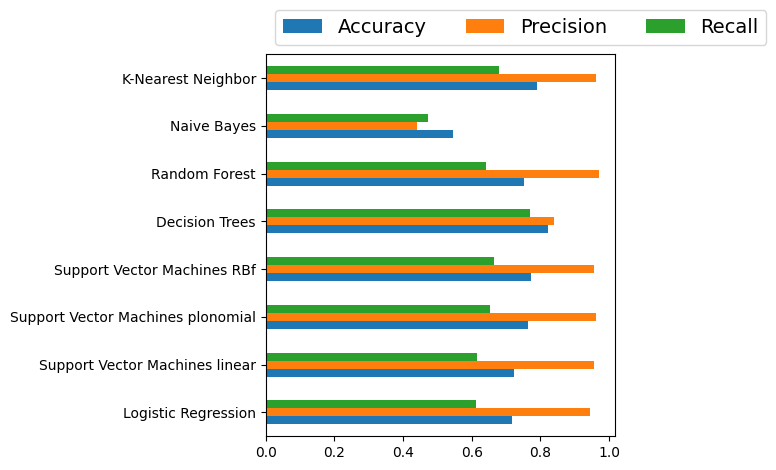

In [24]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()),
    bbox_to_anchor=(0, 1),
    loc='lower left',
    prop={'size': 14}
)
plt.tight_layout()

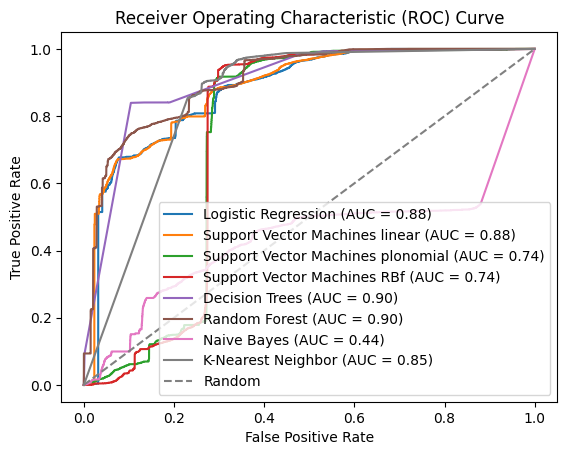

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

# Assuming models is a dictionary containing your trained models

for key in models.keys():
    model = models[key]
    if hasattr(model, "decision_function"):
        model_probs = model.decision_function(x_test)
        model_probs = (model_probs - model_probs.min()) / (model_probs.max() - model_probs.min())  # Normalize scores
    else:
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
        calibrated_model.fit(x_train, y_train)
        model_probs = calibrated_model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
